# LBPH Face recognition

### Loading the dataset

- Yale faces database: http://vision.ucsd.edu/content/yale-face-database

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import display
from PIL import Image
import numpy as np
import zipfile
import seaborn
import cv2
import os

In [2]:
path = '../material/Datasets/yalefaces.zip'
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

### Pre-processing the images

In [3]:
def get_image_data():
    paths = [os.path.join('./yalefaces/train', f) for f in os.listdir('./yalefaces/train')]
    faces = []
    ids = []
    for path in paths:
        image = Image.open(path).convert('L')
        image_np = np.array(image, 'uint8')
        id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
        ids.append(id)
        faces.append(image_np)
        
    return np.array(ids), faces

In [4]:
ids, faces = get_image_data()

In [5]:
ids

array([ 8,  9,  2, 15,  6, 11,  3,  5, 14, 15,  2,  6, 13,  6, 10,  9,  2,
        3, 11, 14,  1,  8, 14, 12, 13, 11,  2, 12, 15, 14,  8, 12,  5,  7,
        7,  1, 13, 10,  5,  6, 11, 14, 15,  2,  2,  4,  7, 12, 13,  2, 14,
       13,  1, 11,  3,  7,  8, 12,  8,  8, 12,  8,  5,  4,  2,  1,  4, 11,
        1,  9,  7, 11,  9, 14, 10,  6, 15,  3, 13,  4,  8,  1,  4,  9, 13,
        4,  5,  3,  5,  1, 14,  1,  5, 10,  7,  8,  9, 13, 10, 15,  6,  7,
        4,  7,  2,  5, 12, 12,  9,  1,  6, 15,  4,  3,  9, 13,  4, 11, 11,
       10,  3, 10, 14,  6, 15, 10, 10, 15,  3,  7,  5, 12,  9,  3,  6])

In [6]:
len(ids)

135

In [7]:
len(faces)

135

In [8]:
faces[0], faces[0].shape

(array([[130, 130, 130, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 246, 221, 213],
        [255, 255, 255, ..., 248, 215, 201],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8),
 (243, 320))

### Training the LBPH classifier

In [9]:
# threshold: 1.7976931348623157e+308
# radius: 1
# neighbors: 8
# grid_x: 8
# grid_y: 8

lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors=14, grid_x = 9, grid_y = 9)
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

### Recognizing faces

In [10]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('lbph_classifier.yml')

In [11]:
test_image = './yalefaces/test/subject10.sad.gif'

In [12]:
image = Image.open(test_image).convert('L')
image_np = np.array(image, 'uint8')
image_np

array([[130, 130, 130, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 241, 255, 255],
       [255, 255, 255, ..., 234, 237, 252],
       [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8)

In [13]:
image_np.shape

(243, 320)

In [14]:
prediction = lbph_face_classifier.predict(image_np)
prediction

(10, 36.84750735484425)

In [15]:
expected_output = int(os.path.split(test_image)[1].split('.')[0].replace('subject', ''))
expected_output

10

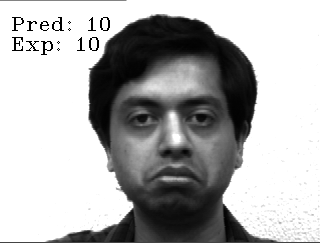

In [16]:
cv2.putText(image_np, 'Pred: ' + str(prediction[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2.putText(image_np, 'Exp: ' + str(expected_output), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))

display(Image.fromarray(image_np))

### Evaluating the face classifier

In [17]:
paths = [os.path.join('./yalefaces/test', f) for f in os.listdir('./yalefaces/test')]
predictions = []
expected_outputs = []
for path in paths:
    image = Image.open(path).convert('L')
    image_np = np.array(image, 'uint8')
    prediction, _ = lbph_face_classifier.predict(image_np)
    expected_output = int(os.path.split(path)[1].split('.')[0].replace('subject', '')) 
    predictions.append(prediction)
    expected_outputs.append(expected_output)

In [18]:
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

In [19]:
predictions

array([13,  1,  3,  9,  7,  8,  4, 14,  7,  4,  7,  4,  5, 12,  4,  9, 13,
       10, 11,  6,  5,  4,  4, 14, 11, 15,  3, 12, 14, 12])

In [20]:
expected_outputs

array([13,  1,  3,  7,  9,  8, 10, 14, 15,  8,  7,  1,  5, 12,  4,  9, 13,
       10, 11,  6,  5,  2,  4, 14, 11, 15,  3, 12,  6,  2])

In [21]:
accuracy_score(expected_outputs, predictions)

0.7

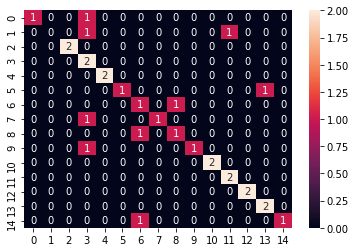

In [23]:
cm = confusion_matrix(expected_outputs, predictions)
seaborn.heatmap(cm, annot=True);

## Dlib